<h2 align="center">Logistic Regression: A Sentiment Analysis Case Study</h2>

### Introduction
___

- IMDB movie reviews dataset
- http://ai.stanford.edu/~amaas/data/sentiment
- Contains 25000 positive and 25000 negative reviews
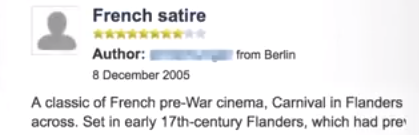
- Contains at most reviews per movie
- At least 7 stars out of 10 $\rightarrow$ positive (label = 1)
- At most 4 stars out of 10 $\rightarrow$ negative (label = 0)
- 50/50 train/test split
- Evaluation accuracy

<b>Features: bag of 1-grams with TF-IDF values</b>:
- Extremely sparse feature matrix - close to 97% are zeros

 <b>Model: Logistic regression</b>
- $p(y = 1|x) = \sigma(w^{T}x)$
- Linear classification model
- Can handle sparse data
- Fast to train
- Weights can be interpreted
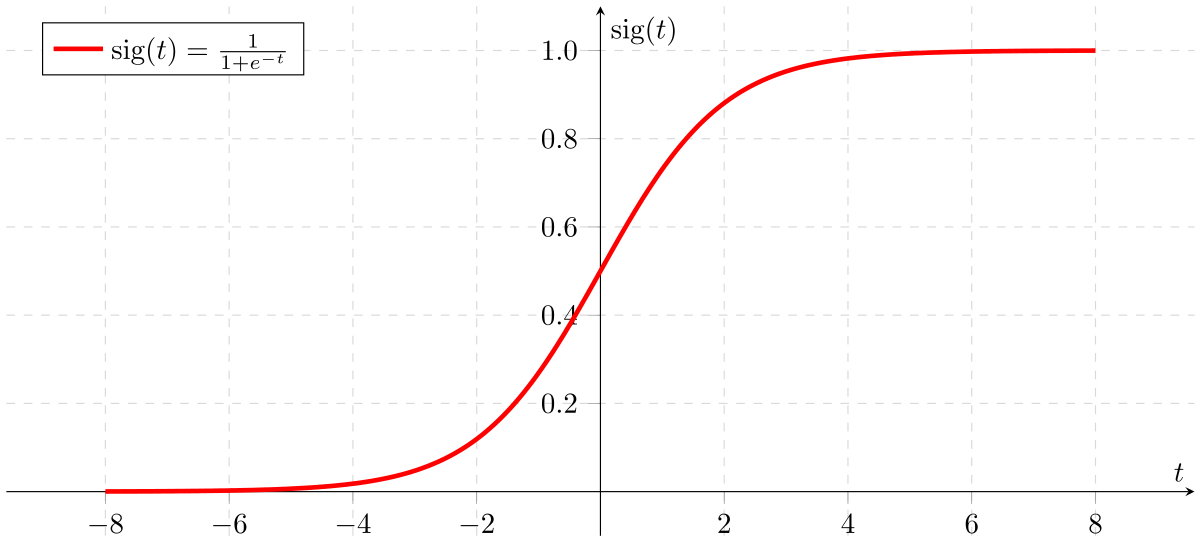

### Loading the dataset
---

In [1]:
import pandas as pd
df = pd.read_csv('data/movie_data.bz2', index_col=0)
df.head(10)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
5,Leave it to Braik to put on a good show. Final...,1
6,Nathan Detroit (Frank Sinatra) is the manager ...,1
7,"To understand ""Crash Course"" in the right cont...",1
8,I've been impressed with Chavez's stance again...,1
9,This movie is directed by Renny Harlin the fin...,1


In [2]:
df.review[0]

'In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />"Murder in Greenwich" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich famil

## <h2 align="center">Bag of words / Bag of N-grams model</h2>

### Transforming documents into feature vectors

Below, we will call the fit_transform method on CountVectorizer. This will construct the vocabulary of the bag-of-words model and transform the following three sentences into sparse feature vectors:
1. The sun is shining
2. The weather is sweet
3. The sun is shining, the weather is sweet, and one and one is two


In [3]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer()

docs = np.array(['The sun is shining',
'The weather is sweet',
'The sun is shining, the weather is sweet, and one and one is two'])
bag = count.fit_transform(docs)

In [4]:
print(count.vocabulary_)

{'the': 6, 'sun': 4, 'is': 1, 'shining': 3, 'weather': 8, 'sweet': 5, 'and': 0, 'one': 2, 'two': 7}


In [5]:
print(bag.toarray())

[[0 1 0 1 1 0 1 0 0]
 [0 1 0 0 0 1 1 0 1]
 [2 3 2 1 1 1 2 1 1]]


Raw term frequencies: *tf (t,d)*—the number of times a term t occurs in a document *d*

### Word relevancy using term frequency-inverse document frequency

$$\text{tf-idf}(t,d)=\text{tf (t,d)}\times \text{idf}(t,d)$$

$$\text{idf}(t,d) = \text{log}\frac{n_d}{1+\text{df}(d, t)},$$

where $n_d$ is the total number of documents, and df(d, t) is the number of documents d that contain the term t.

In [6]:
from sklearn.feature_extraction.text import TfidfTransformer
np.set_printoptions(precision = 2)
tfidf = TfidfTransformer(use_idf = True, norm = 'l2', smooth_idf = True)
print(tfidf.fit_transform(bag).toarray())

[[0.   0.43 0.   0.56 0.56 0.   0.43 0.   0.  ]
 [0.   0.43 0.   0.   0.   0.56 0.43 0.   0.56]
 [0.5  0.45 0.5  0.19 0.19 0.19 0.3  0.25 0.19]]


The equations for the idf and tf-idf that are implemented in scikit-learn are:

$$\text{idf} (t,d) = log\frac{1 + n_d}{1 + \text{df}(d, t)}$$
The tf-idf equation that is implemented in scikit-learn is as follows:

$$\text{tf-idf}(t,d) = \text{tf}(t,d) \times (\text{idf}(t,d)+1)$$

### Data Preparation

In [7]:
df.loc[0, 'review'][-100:]

'lack of the emotion in the dramatization. My vote is seven.<br /><br />Title (Brazil): Not Available'

In [8]:
import re
def preprocessor(text):
    text = re.sub('<[^>]*>', '', text)
    emoticons = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)', text)
    text = re.sub('[\W]+', ' ', text.lower()) +\
        ' '.join(emoticons).replace('-', '')
    return text

In [9]:
preprocessor(df.loc[0, 'review'][-100:])

'lack of the emotion in the dramatization my vote is seven title brazil not available'

In [10]:
preprocessor("This :) is a :( test :-)!")

'this is a test :) :( :)'

In [11]:
df['review'] = df.review.apply(preprocessor)

### Tokenization of documents

In [12]:
from nltk.stem.porter import PorterStemmer

porter= PorterStemmer()

In [13]:
def tokenizer_porter(text):
    return [porter.stem(word) for word in text.split()]

In [14]:
tokenizer_porter('runners like running thus they run')

['runner', 'like', 'run', 'thu', 'they', 'run']

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vinee\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords

stop = stopwords.words('english')

[w for w in tokenizer_porter('runners like running and they run a lot')[-10:] if w not in stop]

['runner', 'like', 'run', 'run', 'lot']

### Transform Text Data into TF-IDF Vectors

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(strip_accents=None,
                       lowercase=False,
                       preprocessor=None,
                       tokenizer=tokenizer_porter,
                       use_idf=True,
                       norm='l2',
                       smooth_idf=True)

y = df.sentiment.values
x = tfidf.fit_transform(df.review)

### Document Classification using Logistic Regression

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(x, y, random_state=1, test_size = 0.15, shuffle = False)

In [19]:
import pickle 
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv=5,
                          scoring='accuracy',
                          random_state=0,
                          n_jobs=-1,
                          verbose=3,
                          max_iter=300).fit(X_train, Y_train)

saved_model = open('saved_model.sav', 'wb')
pickle.dump(clf, saved_model)
saved_model.close()

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  1.8min remaining:  2.7min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished


### Model Evaluation

In [20]:
import pickle
filename = 'saved_model.sav'
saved_clf = pickle.load(open(filename, 'rb'))

In [21]:
saved_clf.score(X_test, Y_test)*100

89.8

In [22]:
from sklearn.metrics import confusion_matrix

In [23]:
X_test

<7500x73814 sparse matrix of type '<class 'numpy.float64'>'
	with 1021143 stored elements in Compressed Sparse Row format>

In [24]:
Y_test

array([0, 1, 0, ..., 0, 0, 1], dtype=int64)

In [25]:
confusion_matrix(Y_test, saved_clf.predict(X_test))

array([[3342,  403],
       [ 362, 3393]], dtype=int64)